## Train-test-split, parameter tuning, cross validation, final testing

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.exceptions import UndefinedMetricWarning, FitFailedWarning
import matplotlib.pyplot as plt

warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)
warnings.filterwarnings(action='ignore', category=FitFailedWarning)


np.random.seed(42)

### Train-test-split

In [19]:
def split(source_file):
    df = pd.read_csv(source_file)
    X = df.drop(['literature_review'], axis=1)
    y = df['literature_review']
    X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.25, random_state=42)
    return X_train, X_test, y_train, y_test

### Parameter tuning and testing
- various parameters are tested for each algorithm using sklearn's GridSearchCV
- the parameters are evaluated using cross validation
- the best parameters are used for training the model
- the model is then tested on the testing data

In [20]:
def tune_params(X_train,y_train,X_test,y_test,pipeline,params):
    grid_search = GridSearchCV(estimator=pipeline, param_grid=params, scoring=['f1','recall','precision'],cv=5, refit='f1')
    grid_search.fit(X_train,y_train)
    y_pred = grid_search.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    print(f"     f1: {f1}\n     recall: {recall}\n      precision: {precision}")
    return f1,recall,precision

def train_and_test(source_path):
    X_train, X_test, y_train, y_test = split(source_path)
    f1_scores = {}
    recall_scores = {}
    precision_scores = {}

    # Logistic Regression
    lr_pipeline = Pipeline([('scaler', StandardScaler()),('lr', LogisticRegression(max_iter=200))])
    lr_params = {'lr__penalty':['l1','l2'], 
                'lr__C':[1, 10, 100, 1000],
                'lr__class_weight': [None, 'balanced']}
    print('Logistic Regression:')
    f1, recall, precision = tune_params(X_train, y_train, X_test, y_test, lr_pipeline, lr_params)
    f1_scores['LR'] = f1
    recall_scores['LR'] = recall
    precision_scores['LR'] = precision

    # Support Vector Machines
    svm_pipeline = Pipeline([('scaler', StandardScaler()),('svm', SVC())])
    svm_params = {'svm__C': [0.1, 1, 10],  
                'svm__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
                'svm__kernel': ['rbf'],
                'svm__class_weight': [None, 'balanced']}
    print('Support Vector Machines:')
    f1, recall, precision = tune_params(X_train, y_train, X_test, y_test, svm_pipeline, svm_params)
    f1_scores['SVM'] = f1
    recall_scores['SVM'] = recall
    precision_scores['SVM'] = precision

    # Naive Bayes
    nb = GaussianNB()
    nb.fit(X_train, y_train)
    y_pred = nb.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    print('Naive Bayes:')
    print(f"     f1: {f1}\n     recall: {recall}\n      precision: {precision}")
    f1_scores['NB'] = f1
    recall_scores['NB'] = recall
    precision_scores['NB'] = precision
   
    # Decision Trees
    dt_pipeline = Pipeline([('dt', DecisionTreeClassifier())])
    dt_params = {'dt__criterion': ['gini', 'entropy'], 
                'dt__max_depth':range(1,10),
                'dt__class_weight': [None, 'balanced']}
    print('Decision Trees:')
    f1, recall, precision = tune_params(X_train, y_train, X_test, y_test, dt_pipeline, dt_params)
    f1_scores['DT'] = f1
    recall_scores['DT'] = recall
    precision_scores['DT'] = precision

    # Random Forest
    rf_pipeline = Pipeline([('rf', RandomForestClassifier())])
    rf_params = {'rf__bootstrap': [True, False],
                 'rf__max_depth': [3, 6, 9, None],
                 'rf__max_features': ['auto', 'sqrt'],
                 'rf__n_estimators': [25, 50, 100, 150],
                 'rf__class_weight': [None, 'balanced']}
    print(f'Random Forest:')
    f1, recall, precision = tune_params(X_train, y_train, X_test, y_test, rf_pipeline, rf_params)
    f1_scores['RF'] = f1
    recall_scores['RF'] = recall
    precision_scores['RF'] = precision


    # k-nearest neighbor
    knn_pipeline = Pipeline([('scaler', StandardScaler()),('knn', KNeighborsClassifier())])
    knn_params = {'knn__n_neighbors': range(1,10),  
                'knn__weights': ['uniform', 'distance']}
    print(f'K-nearest neighbor:')
    f1, recall, precision = tune_params(X_train, y_train, X_test, y_test, knn_pipeline, knn_params)
    f1_scores['kNN'] = f1
    recall_scores['kNN'] = recall
    precision_scores['kNN'] = precision
    
    # Balanced Random Forest
    brf_pipeline = imbpipeline([('brf', BalancedRandomForestClassifier())])
    brf_params = {'brf__bootstrap': [True, False],
                 'brf__max_depth': [3, 6, 9, None],
                 'brf__max_features': ['auto', 'sqrt'],
                 'brf__n_estimators': [25, 50, 100, 150],
                 'brf__class_weight': [None, 'balanced']}
    print(f'Balanced Random Forest:')
    f1, recall, precision = tune_params(X_train, y_train, X_test, y_test, brf_pipeline, brf_params)
    f1_scores['BRF'] = f1
    recall_scores['BRF'] = recall
    precision_scores['BRF'] = precision

    return f1_scores, recall_scores, precision_scores


### Graph for visualizing the results

In [21]:
def make_graph(f1, recall, precision):
    
    del f1['NB']
    del f1['kNN']
    del recall['NB']
    del recall['kNN']
    del precision['NB']
    del precision['kNN']
    
    plt.figure(figsize=(8,6))
    plt.bar(x=[0,5,10,15,20], height=list(f1.values()), width=0.9, color="tomato", label="f1")
    plt.bar(x=[1,6,11,16,21], height=list(precision.values()), width=0.9, color="dodgerblue", label="precision")
    plt.bar(x=[2,7,12,17,22], height=list(recall.values()), width=0.9, color="lime", label="recall")

    plt.xlabel("algorithm")
    plt.ylabel("metric score")

    plt.xticks(ticks=[1.5, 6.5, 11.5, 16.5, 21.5], labels=list(f1_scores.keys()), rotation=45)
    plt.legend(loc='best')
    plt.show()


### All feature combinations are tested on both datasets

- - - original dataset, keywords feature - - -
Logistic Regression:


/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan 0.09487179        nan 0.31149068        nan 0.14153846
        nan 0.31547956        nan 0.12307692        nan 0.32799809
        nan 0.13653846        nan 0.32799809]
  warnings.warn(
/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan 0.05818182        nan 0.39272727        nan 0.09818182
        nan 0.39272727        nan 0.07818182        nan 0.39272727
        nan 0.09818182        nan 0.39272727]
  warnings.warn(
/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan 0.26666667        nan 0.26512821        nan 0.28666667
        nan 0.27167277        nan 0.3               nan 0.29131313
        nan 0.26666667      

     f1: 0.3111111111111111
     recall: 0.4375
      precision: 0.2413793103448276
Support Vector Machines:
     f1: 0.4117647058823529
     recall: 0.4375
      precision: 0.3888888888888889
Naive Bayes:
     f1: 0.05871559633027523
     recall: 1.0
      precision: 0.030245746691871456
Decision Trees:
     f1: 0.4117647058823529
     recall: 0.4375
      precision: 0.3888888888888889
Random Forest:


/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.         0.
 0.         0.                nan        nan        nan        nan
 0.03333333 0.         0.         0.                nan        nan
        nan        nan 0.1004662  0.03333333 0.1004662  0.03333333
        nan        nan        nan        nan 0.03333333 0.06410256
 0.06410256 0.03333333        nan        nan        nan        nan
 0.31820566 0.31534971 0.3133447  0.31741834        nan        nan
        nan        nan 0.3109077  0.30655988 0.29870727 0.30448015
        nan        nan        nan        nan 0.28265415 0.30477744
 0.29609289 0.2913387         nan        nan        nan        nan
 0.30655988 0.29395308 0.2913387  0.2913387         nan        nan
        nan        nan 0.         0.         0.         0.
        nan        nan        nan        nan 0.03333333 0.033333

     f1: 0.3181818181818182
     recall: 0.4375
      precision: 0.25
K-nearest neighbor:
     f1: 0.4
     recall: 0.375
      precision: 0.42857142857142855
Balanced Random Forest:


/home/luca/.local/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/luca/.local/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/home/luca/.local/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.


     f1: 0.2978723404255319
     recall: 0.4375
      precision: 0.22580645161290322


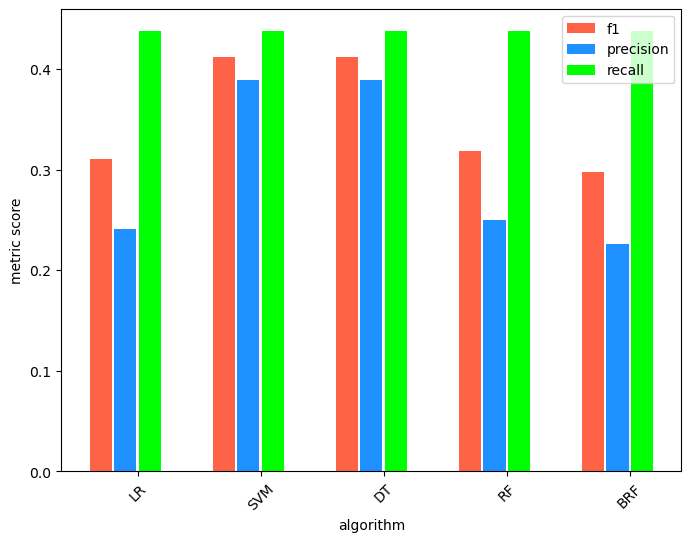

- - - original dataset, references feature - - -
Logistic Regression:


/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan 0.09487179        nan 0.31149068        nan 0.14153846
        nan 0.31547956        nan 0.11868132        nan 0.32799809
        nan 0.1321267         nan 0.32799809]
  warnings.warn(
/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan 0.05818182        nan 0.39272727        nan 0.09818182
        nan 0.39272727        nan 0.07818182        nan 0.39272727
        nan 0.09818182        nan 0.39272727]
  warnings.warn(
/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan 0.26666667        nan 0.26512821        nan 0.28666667
        nan 0.27167277        nan 0.26666667        nan 0.29131313
        nan 0.25238095      

     f1: 0.3404255319148936
     recall: 0.5
      precision: 0.25806451612903225
Support Vector Machines:
     f1: 0.42105263157894735
     recall: 0.5
      precision: 0.36363636363636365
Naive Bayes:
     f1: 0.05871559633027523
     recall: 1.0
      precision: 0.030245746691871456
Decision Trees:
     f1: 0.42105263157894735
     recall: 0.5
      precision: 0.36363636363636365
Random Forest:


/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.         0.
 0.         0.                nan        nan        nan        nan
 0.         0.         0.03333333 0.                nan        nan
        nan        nan 0.1004662  0.13123543 0.1004662  0.06969697
        nan        nan        nan        nan 0.1004662  0.13123543
 0.13123543 0.1030303         nan        nan        nan        nan
 0.29459816 0.30931677 0.31307051 0.3012536         nan        nan
        nan        nan 0.31959225 0.29870727 0.3109077  0.30477744
        nan        nan        nan        nan 0.2913387  0.2935164
 0.30477744 0.28526853        nan        nan        nan        nan
 0.28738613 0.29609289 0.29000051 0.30477744        nan        nan
        nan        nan 0.         0.         0.         0.
        nan        nan        nan        nan 0.06969697 0.0696969

     f1: 0.3111111111111111
     recall: 0.4375
      precision: 0.2413793103448276
K-nearest neighbor:
     f1: 0.36363636363636365
     recall: 0.375
      precision: 0.35294117647058826
Balanced Random Forest:


/home/luca/.local/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/luca/.local/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/home/luca/.local/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.


     f1: 0.32
     recall: 0.5
      precision: 0.23529411764705882


/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.28818954 0.30332468
 0.29696552 0.30332468        nan        nan        nan        nan
 0.25652714 0.27087061 0.25041723 0.27330083        nan        nan
        nan        nan 0.28429344 0.25683038 0.27159386 0.24830083
        nan        nan        nan        nan 0.2407981  0.28788671
 0.25048366 0.24382222        nan        nan        nan        nan
 0.06182395 0.06182395 0.06178842 0.06178842        nan        nan
        nan        nan 0.06313997 0.06314652 0.06501087 0.0643851
        nan        nan        nan        nan 0.06300335 0.06402075
 0.06377386 0.06329378        nan        nan        nan        nan
 0.06274176 0.06419592 0.06394163 0.06300458        nan        nan
        nan        nan 0.27377669 0.30332468 0.30332468 0.29696552
        nan        nan        nan        nan 0.24

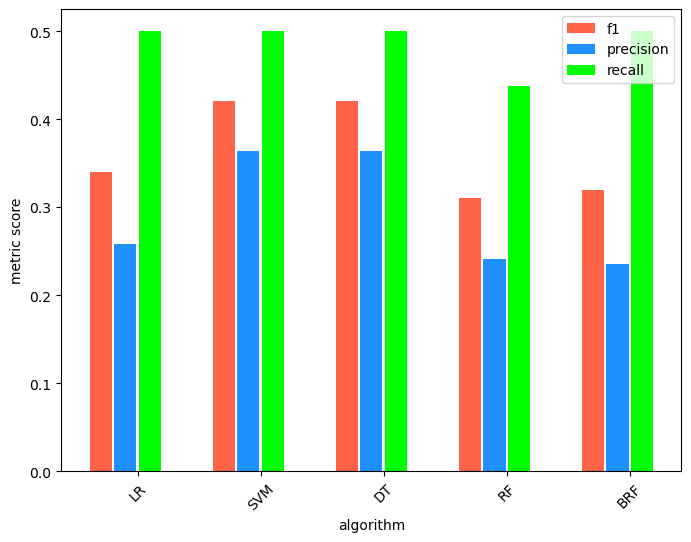

- - - original dataset, text mining feature - - -
Logistic Regression:


/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan 0.21303651        nan 0.19901478        nan 0.19437556
        nan 0.17467507        nan 0.19030297        nan 0.14746224
        nan 0.1841603         nan 0.13680205]
  warnings.warn(
/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan 0.17272727        nan 0.30363636        nan 0.19272727
        nan 0.28727273        nan 0.24727273        nan 0.23272727
        nan 0.26727273        nan 0.24909091]
  warnings.warn(
/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan 0.3002381         nan 0.15061198        nan 0.20404762
        nan 0.12993179        nan 0.1634278         nan 0.10831091
        nan 0.15288264      

     f1: 0.13333333333333333
     recall: 0.125
      precision: 0.14285714285714285
Support Vector Machines:
     f1: 0.3448275862068966
     recall: 0.3125
      precision: 0.38461538461538464
Naive Bayes:
     f1: 0.08333333333333333
     recall: 0.3125
      precision: 0.04807692307692308
Decision Trees:
     f1: 0.4
     recall: 0.375
      precision: 0.42857142857142855
Random Forest:


/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.         0.
 0.         0.                nan        nan        nan        nan
 0.         0.         0.         0.                nan        nan
        nan        nan 0.03636364 0.         0.03636364 0.
        nan        nan        nan        nan 0.11868132 0.09350649
 0.12683983 0.16320346        nan        nan        nan        nan
 0.32049354 0.22240565 0.31668552 0.27267399        nan        nan
        nan        nan 0.21255183 0.2621728  0.26039329 0.29024975
        nan        nan        nan        nan 0.16615801 0.20024814
 0.18729602 0.24676692        nan        nan        nan        nan
 0.13890959 0.13217391 0.10734066 0.09412327        nan        nan
        nan        nan 0.         0.         0.         0.
        nan        nan        nan        nan 0.06969697 0.03636364
 0.06

     f1: 0.20588235294117646
     recall: 0.4375
      precision: 0.1346153846153846
K-nearest neighbor:
     f1: 0.1875
     recall: 0.1875
      precision: 0.1875
Balanced Random Forest:


/home/luca/.local/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/luca/.local/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/home/luca/.local/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.


     f1: 0.15172413793103448
     recall: 0.6875
      precision: 0.08527131782945736


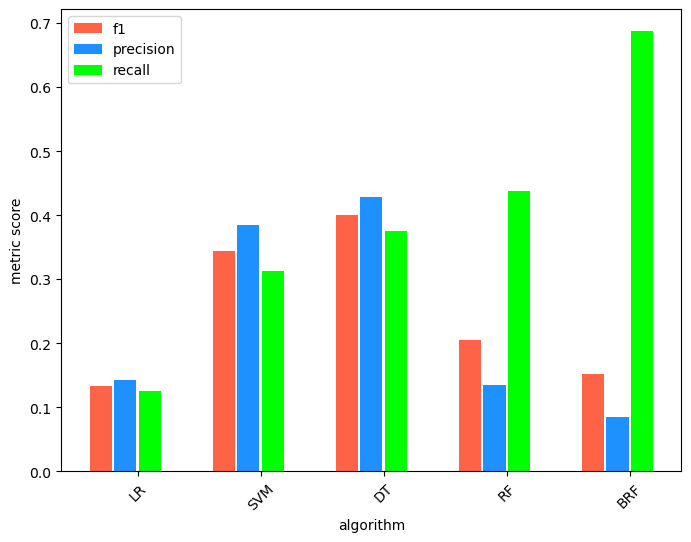

- - - extended dataset, keywords feature - - -
Logistic Regression:


/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan 0.15167048        nan 0.27925321        nan 0.14645309
        nan 0.29149648        nan 0.14355454        nan 0.29824174
        nan 0.14355454        nan 0.29891971]
  warnings.warn(
/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan 0.08954248        nan 0.42745098        nan 0.08954248
        nan 0.42745098        nan 0.08954248        nan 0.42745098
        nan 0.08954248        nan 0.42745098]
  warnings.warn(
/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan 0.66              nan 0.20851045        nan 0.54
        nan 0.22308123        nan 0.51333333        nan 0.23122592
        nan 0.51333333        nan 

     f1: 0.29473684210526313
     recall: 0.45161290322580644
      precision: 0.21875
Support Vector Machines:
     f1: 0.3235294117647059
     recall: 0.3548387096774194
      precision: 0.2972972972972973
Naive Bayes:
     f1: 0.060665362035225046
     recall: 1.0
      precision: 0.03128153380423814
Decision Trees:
     f1: 0.3235294117647059
     recall: 0.3548387096774194
      precision: 0.2972972972972973
Random Forest:


/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.         0.
 0.         0.                nan        nan        nan        nan
 0.13178744 0.06222222 0.13494949 0.1337799         nan        nan
        nan        nan 0.1297321  0.1297321  0.1297321  0.12657005
        nan        nan        nan        nan 0.1297321  0.12657005
 0.12250191 0.1297321         nan        nan        nan        nan
 0.29216999 0.28801278 0.29019996 0.29334848        nan        nan
        nan        nan 0.28594199 0.27920558 0.29488667 0.27476113
        nan        nan        nan        nan 0.28652554 0.28536444
 0.2774697  0.2807772         nan        nan        nan        nan
 0.26979076 0.28212994 0.2807772  0.2807772         nan        nan
        nan        nan 0.         0.         0.         0.
        nan        nan        nan        nan 0.07805746 0.077004

     f1: 0.3146067415730337
     recall: 0.45161290322580644
      precision: 0.2413793103448276
K-nearest neighbor:
     f1: 0.0
     recall: 0.0
      precision: 0.0
Balanced Random Forest:


/home/luca/.local/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/luca/.local/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/home/luca/.local/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.


     f1: 0.30434782608695654
     recall: 0.45161290322580644
      precision: 0.22950819672131148


/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.25379703 0.27562488
 0.27106311 0.27580556        nan        nan        nan        nan
 0.26856344 0.2676142  0.27099907 0.26541522        nan        nan
        nan        nan 0.26630807 0.26630807 0.27393833 0.26541522
        nan        nan        nan        nan 0.27067143 0.27447388
 0.27497853 0.26505317        nan        nan        nan        nan
 0.05740248 0.05721736 0.05721345 0.05742349        nan        nan
        nan        nan 0.06399566 0.06393945 0.06378161 0.06387293
        nan        nan        nan        nan 0.06425827 0.06435834
 0.06411078 0.06382438        nan        nan        nan        nan
 0.06394472 0.06399002 0.06412869 0.06398466        nan        nan
        nan        nan 0.28375724 0.27577115 0.27641723 0.27260729
        nan        nan        nan        nan 0.2

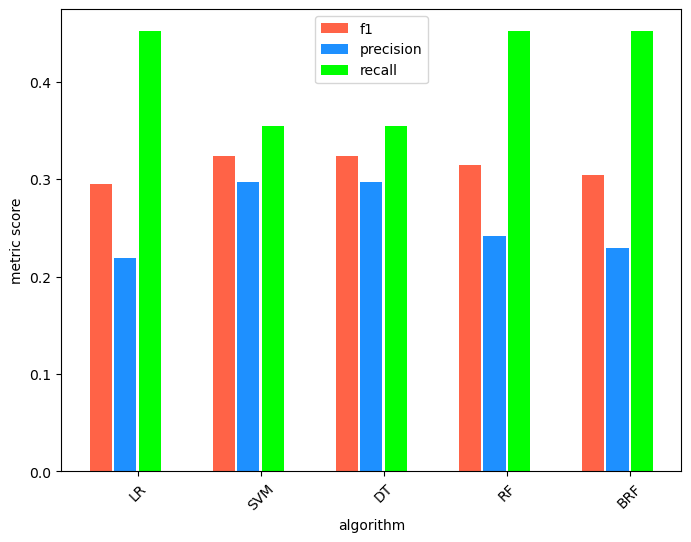

- - - extended dataset, references feature - - -
Logistic Regression:


/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan 0.18375104        nan 0.28709392        nan 0.17660819
        nan 0.29447945        nan 0.17327485        nan 0.29871096
        nan 0.17327485        nan 0.30414849]
  warnings.warn(
/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan 0.11176471        nan 0.4496732         nan 0.11176471
        nan 0.4496732         nan 0.11176471        nan 0.4496732
        nan 0.11176471        nan 0.4496732 ]
  warnings.warn(
/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan 0.76666667        nan 0.21225296        nan 0.66666667
        nan 0.22100193        nan 0.64285714        nan 0.22538316
        nan 0.64285714       

     f1: 0.30303030303030304
     recall: 0.4838709677419355
      precision: 0.22058823529411764
Support Vector Machines:
     f1: 0.3235294117647059
     recall: 0.3548387096774194
      precision: 0.2972972972972973
Naive Bayes:
     f1: 0.060665362035225046
     recall: 1.0
      precision: 0.03128153380423814
Decision Trees:
     f1: 0.3235294117647059
     recall: 0.3548387096774194
      precision: 0.2972972972972973
Random Forest:


/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.         0.
 0.         0.                nan        nan        nan        nan
 0.11010101 0.13304473 0.11010101 0.13304473        nan        nan
        nan        nan 0.13555556 0.12512077 0.12512077 0.12512077
        nan        nan        nan        nan 0.12222222 0.12512077
 0.12828283 0.12512077        nan        nan        nan        nan
 0.29532443 0.29572289 0.29597242 0.29068571        nan        nan
        nan        nan 0.28469409 0.29655347 0.28809681 0.29655347
        nan        nan        nan        nan 0.28861284 0.28978167
 0.28188693 0.28188693        nan        nan        nan        nan
 0.27842373 0.28188693 0.27850135 0.27586408        nan        nan
        nan        nan 0.02105263 0.         0.         0.
        nan        nan        nan        nan 0.12988268 0.129882

     f1: 0.3125
     recall: 0.4838709677419355
      precision: 0.23076923076923078
K-nearest neighbor:
     f1: 0.05555555555555555
     recall: 0.03225806451612903
      precision: 0.2
Balanced Random Forest:


/home/luca/.local/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/luca/.local/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/home/luca/.local/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.


     f1: 0.297029702970297
     recall: 0.4838709677419355
      precision: 0.21428571428571427


/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.27435277 0.29773489
 0.28523258 0.28296388        nan        nan        nan        nan
 0.2828083  0.27362376 0.27776969 0.27851004        nan        nan
        nan        nan 0.26979872 0.2710611  0.27776969 0.2789308
        nan        nan        nan        nan 0.27016447 0.27776969
 0.27347104 0.27054723        nan        nan        nan        nan
 0.05742282 0.05710593 0.05721784 0.05706786        nan        nan
        nan        nan 0.06232343 0.06332314 0.06351555 0.0630313
        nan        nan        nan        nan 0.06411752 0.06406343
 0.06431338 0.06395993        nan        nan        nan        nan
 0.06435696 0.06417348 0.06385097 0.06384934        nan        nan
        nan        nan 0.30031615 0.28220658 0.28433455 0.27989011
        nan        nan        nan        nan 0.281

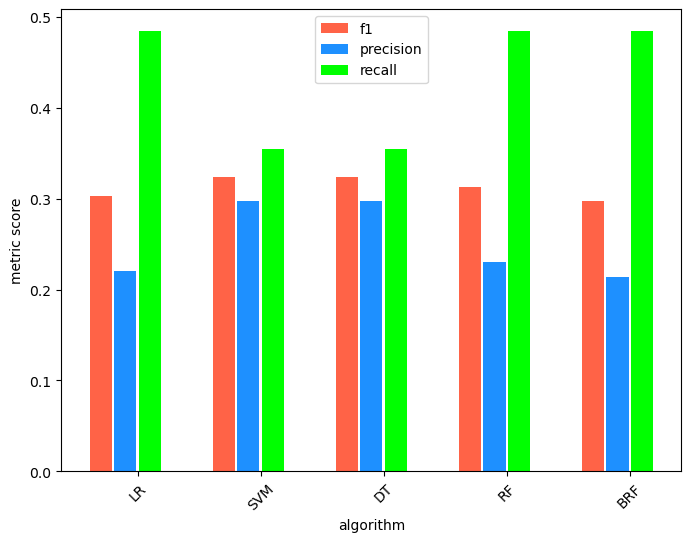

- - - extended dataset, text mining feature - - -
Logistic Regression:


/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan 0.26714816        nan 0.20652266        nan 0.22274018
        nan 0.16451325        nan 0.18922579        nan 0.14177807
        nan 0.17920716        nan 0.13563169]
  warnings.warn(
/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan 0.22418301        nan 0.34901961        nan 0.2130719
        nan 0.28104575        nan 0.2248366         nan 0.29215686
        nan 0.2248366         nan 0.30326797]
  warnings.warn(
/home/luca/.local/lib/python3.11/site-packages/sklearn/model_selection/_search.py:1051: UserWarning: One or more of the test scores are non-finite: [       nan 0.33858974        nan 0.14774389        nan 0.2389899
        nan 0.11797358        nan 0.16604701        nan 0.09432396
        nan 0.15246308        

     f1: 0.4444444444444444
     recall: 0.3870967741935484
      precision: 0.5217391304347826
Support Vector Machines:


In [22]:
print("- - - original dataset, keywords feature - - -")
f1_scores, recall_scores, precision_scores = train_and_test("../../data/processed/original_dataset/data_key.csv")
make_graph(f1_scores, recall_scores, precision_scores)

print("- - - original dataset, references feature - - -")
f1_scores, recall_scores, precision_scores = train_and_test("../../data/processed/original_dataset/data_ref.csv")
make_graph(f1_scores, recall_scores, precision_scores)

print("- - - original dataset, text mining feature - - -")
f1_scores, recall_scores, precision_scores = train_and_test("../../data/processed/original_dataset/data_tm.csv")
make_graph(f1_scores, recall_scores, precision_scores)

print("- - - extended dataset, keywords feature - - -")
f1_scores, recall_scores, precision_scores = train_and_test("../../data/processed/extended_dataset/data_key.csv")
make_graph(f1_scores, recall_scores, precision_scores)

print("- - - extended dataset, references feature - - -")
f1_scores, recall_scores, precision_scores = train_and_test("../../data/processed/extended_dataset/data_ref.csv")
make_graph(f1_scores, recall_scores, precision_scores)

print("- - - extended dataset, text mining feature - - -")
f1_scores, recall_scores, precision_scores = train_and_test("../../data/processed/extended_dataset/data_tm.csv")
make_graph(f1_scores, recall_scores, precision_scores)
